In [44]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.models import resnet101
from torchvision.transforms import v2
from torch.utils.data import DataLoader

# seed
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [45]:
# model
model = resnet101(weights="IMAGENET1K_V1")
model = nn.DataParallel(model)
model.to(device)

# data
img_paths = glob.glob("./data/Zeiler-Fergus/*")
labels = [366, 355, 312, 261, 298]

In [46]:
img_paths[2]

'./data/Zeiler-Fergus/cricket.jpg'

In [47]:
'''課題3.2
Zeiler-FergusによるCNNの可視化
'''

img_idx = 2
o_img = read_image(img_paths[img_idx])
label = labels[img_idx]

In [48]:
# exp
def apply_occluder(img: torch.Tensor, occluder: torch.Tensor, x: int, y:int):
    '''
    任意の位置(x, y)にoccluderを適用する関数
    x: x座標
    y: y座標
    '''
    H, W = img.shape[1], img.shape[2]
    img_occ = img.clone()
    x1, y1 = x, y
    x2, y2 = x1 + occluder.shape[2], y1 + occluder.shape[1]

    # クリップ範囲
    x1i, y1i = max(x1, 0), max(y1, 0)
    x2i, y2i = min(x2, W), min(y2, H)

    # occluder内の対応する領域
    ox1, oy1 = x1i - x1, y1i - y1
    ox2, oy2 = ox1 + (x2i - x1i), oy1 + (y2i - y1i)

    # 合成
    img_occ[:, y1i:y2i, x1i:x2i] = occluder[:, oy1:oy2, ox1:ox2]
    return img_occ, x1i, y1i, x2i, y2i

transform_1 = v2.Compose([
    v2.Resize([256, 256]),
    v2.ToDtype(torch.float, scale=True),
])
transform_2 = v2.Compose([
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_1 = transform_1(o_img)
img_2 = transform_2(img_1)

occluder = torch.zeros((3, 64, 64), dtype=img_2.dtype)

softmax=nn.Softmax(dim=1)
model.eval()
per_pixel_out_list = torch.zeros(256, 256)
per_pixel_count = torch.zeros(256, 256)
with torch.no_grad():
    for x in range(-56, 248, 8):
        for y in range(-56, 248, 8):
            img_occ, x1, y1, x2, y2 = apply_occluder(img_2, occluder, x, y)
            img_occ = img_occ.unsqueeze(0).to(device)
            output = model(img_occ).cpu()
            prob = softmax(output)[0][label]
            for x_ in range(x1, x2):
                for y_ in range(y1, y2):
                    per_pixel_out_list[y_][x_] += prob
                    per_pixel_count[y_][x_] += 1

In [49]:
# 確率マップの作成
p_map = per_pixel_out_list / per_pixel_count
p_map

tensor([[2.9639e-09, 2.9639e-09, 2.9639e-09,  ..., 2.4307e-09, 2.4307e-09,
         2.4307e-09],
        [2.9639e-09, 2.9639e-09, 2.9639e-09,  ..., 2.4307e-09, 2.4307e-09,
         2.4307e-09],
        [2.9639e-09, 2.9639e-09, 2.9639e-09,  ..., 2.4307e-09, 2.4307e-09,
         2.4307e-09],
        ...,
        [6.0211e-09, 6.0211e-09, 6.0211e-09,  ..., 5.1506e-09, 5.1506e-09,
         5.1506e-09],
        [6.0211e-09, 6.0211e-09, 6.0211e-09,  ..., 5.1506e-09, 5.1506e-09,
         5.1506e-09],
        [6.0211e-09, 6.0211e-09, 6.0211e-09,  ..., 5.1506e-09, 5.1506e-09,
         5.1506e-09]])

In [50]:
# Heatmap


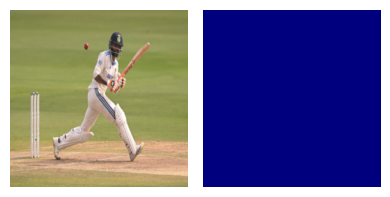

In [51]:
img_occ = apply_occluder(img_2, occluder, 0, 0)

# vis
fig, axs = plt.subplots(1, 2, figsize=(4,4))
axs[0].imshow(img_1.permute(1, 2, 0))
axs[0].axis('off')

axs[1].imshow(p_map, cmap='jet', vmin=0, vmax=1)
axs[1].axis('off')

plt.tight_layout()
plt.show()